In [1]:
import pandas as pd
import numpy as np
import re

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [2]:
data = pd.read_csv('data/annual_stock.csv')
data['Stock number'] = data['Stock number'].astype(str)
data['Year (end of the year)'] = data['Year (end of the year)'].astype(str)
data

,Stock number,Year (end of the year),Total fixed assets,Interest -free liability,Interest -free non -current liabilities,Interest liabilities,Interest debt,Net debt,Formal asset,Operating capital,...,Cash and cash equivalent net increase,Add: At the beginning of the period of cash and cash equivalent,Special items for cash and cash equivalents,The amount of adjustment of the net increase in cash and cash equivalent,At the end of the period of cash and cash equivalent,High transfer preparation announcement date,High transfer of equity registration date,High transfer removal day,Turn per share,Whether to transfer
0,1,1,8.691229e+07,1.422495e+09,1.600192e+08,8.198551e+08,8.271884e+08,3.578747e+08,8.929308e+08,5.904970e+08,...,-7.615285e+07,5.454666e+08,NaN,NaN,4.693137e+08,3月30日,NaN,NaN,NaN,0
1,1,2,7.887817e+07,1.903724e+09,1.487364e+08,3.749099e+08,3.942266e+08,-4.034978e+08,1.190906e+09,9.114353e+08,...,3.284106e+08,4.693137e+08,NaN,NaN,7.977243e+08,3月30日,NaN,NaN,NaN,0
2,1,3,7.530102e+07,1.447218e+09,1.418316e+08,3.643167e+08,4.805600e+08,-4.966118e+08,1.501162e+09,1.333070e+09,...,1.794475e+08,7.977243e+08,NaN,NaN,9.771718e+08,4月1日,6月19日,6月20日,0.25,0
3,1,4,6.406923e+07,1.388840e+09,1.367301e+08,1.050000e+08,2.826134e+08,-5.263500e+08,1.755344e+09,1.697810e+09,...,-1.682084e+08,9.771718e+08,NaN,NaN,8.089634e+08,4月1日,6月8日,6月9日,0.22,0
4,1,5,8.592952e+07,1.870206e+09,1.347049e+08,1.292434e+08,2.740834e+08,-6.716566e+08,1.764907e+09,1.665822e+09,...,1.243744e+08,8.089634e+08,NaN,NaN,9.333378e+08,3月31日,5月23日,5月24日,0.08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24257,3466,3,1.749089e+08,9.162246e+07,1.583035e+07,6.589091e+07,6.589091e+07,9.880669e+06,2.252468e+08,6.080053e+07,...,1.811266e+07,3.400758e+07,NaN,NaN,5.212024e+07,NaN,NaN,NaN,NaN,0
24258,3466,4,1.674375e+08,1.017815e+08,1.360359e+07,2.314488e+07,2.314488e+07,-1.139792e+08,3.873122e+08,2.294332e+08,...,7.917448e+07,5.212024e+07,NaN,NaN,1.312947e+08,4月9日,5月22日,5月25日,0.20,0
24259,3466,5,1.627839e+08,8.110693e+07,1.326047e+07,1.415562e+07,1.415562e+07,-1.464317e+06,3.651500e+08,2.133559e+08,...,-1.178085e+08,1.312947e+08,NaN,NaN,1.348623e+07,4月26日,6月6日,6月7日,0.11,0
24260,3466,6,1.897513e+08,1.432359e+08,1.203168e+07,2.974001e+07,2.974001e+07,-4.736971e+07,3.793057e+08,2.000272e+08,...,5.956293e+07,1.348623e+07,NaN,NaN,7.304916e+07,4月26日,6月7日,6月8日,0.11,0


#### Step 1: Handling missing values

In [3]:
# Check the percentage of missing values in each column
missing_values = data.isnull().mean() * 100

# Removing columns with a high percentage of missing values (e.g., more than 50% missing)
threshold = 50  # percentage
columns_to_drop = missing_values[missing_values > threshold].index
data_cleaned = data.drop(columns=columns_to_drop)

# Removing columns that are not useful for the analysis
data_cleaned.drop(columns=['High transfer preparation announcement date', 'High transfer of equity registration date',
                           'High transfer removal day'], inplace=True)

# Removing rows with a high percentage of missing values 
rows_to_drop = data_cleaned.isnull().mean(axis=1) * 100 > threshold
data_cleaned = data_cleaned[~rows_to_drop]


# For the remaining columns, if they are numeric, fill missing values with the median, 
# and if they are categorical, fill with the mode
for col in data_cleaned.columns:
    if data_cleaned[col].dtype == 'object':
        # fill with the most frequent value (mode)
        data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].mode()[0])
    else:
        # fill with median
        data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].median())

# Display the updated DataFrame
data_cleaned


,Stock number,Year (end of the year),Total fixed assets,Interest -free liability,Interest -free non -current liabilities,Interest liabilities,Interest debt,Net debt,Formal asset,Operating capital,...,"Dividement, profit, or payment of interest payment cash",Payment other cash related to fundraising activities,Cash outflow of fundraising activities,Net cash flow from financing activities,effect of the changes of the exchange rate on cash and the equivalents,Cash and cash equivalent net increase,Add: At the beginning of the period of cash and cash equivalent,At the end of the period of cash and cash equivalent,Turn per share,Whether to transfer
0,1,1,8.691229e+07,1.422495e+09,1.600192e+08,8.198551e+08,8.271884e+08,3.578747e+08,8.929308e+08,5.904970e+08,...,4.396870e+07,1396200.00,3.243249e+08,2.881703e+08,-217885.53,-7.615285e+07,5.454666e+08,4.693137e+08,0.13,0
1,1,2,7.887817e+07,1.903724e+09,1.487364e+08,3.749099e+08,3.942266e+08,-4.034978e+08,1.190906e+09,9.114353e+08,...,4.891714e+07,1584500.00,6.694635e+08,-4.834635e+08,1103.36,3.284106e+08,4.693137e+08,7.977243e+08,0.13,0
2,1,3,7.530102e+07,1.447218e+09,1.418316e+08,3.643167e+08,4.805600e+08,-4.966118e+08,1.501162e+09,1.333070e+09,...,2.337307e+07,1677492.00,3.973809e+08,6.386246e+07,-801465.87,1.794475e+08,7.977243e+08,9.771718e+08,0.25,0
3,1,4,6.406923e+07,1.388840e+09,1.367301e+08,1.050000e+08,2.826134e+08,-5.263500e+08,1.755344e+09,1.697810e+09,...,1.787611e+08,17131885.01,6.930777e+08,-3.767077e+08,-1093973.32,-1.682084e+08,9.771718e+08,8.089634e+08,0.22,0
4,1,5,8.592952e+07,1.870206e+09,1.347049e+08,1.292434e+08,2.740834e+08,-6.716566e+08,1.764907e+09,1.665822e+09,...,1.492891e+08,104500.00,3.743936e+08,-1.579236e+08,2757607.83,1.243744e+08,8.089634e+08,9.333378e+08,0.08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24257,3466,3,1.749089e+08,9.162246e+07,1.583035e+07,6.589091e+07,6.589091e+07,9.880669e+06,2.252468e+08,6.080053e+07,...,2.466474e+07,17131885.01,5.466474e+07,5.335261e+06,-8344.27,1.811266e+07,3.400758e+07,5.212024e+07,0.13,0
24258,3466,4,1.674375e+08,1.017815e+08,1.360359e+07,2.314488e+07,2.314488e+07,-1.139792e+08,3.873122e+08,2.294332e+08,...,1.615895e+07,17131885.01,9.615895e+07,6.047802e+07,-8344.27,7.917448e+07,5.212024e+07,1.312947e+08,0.20,0
24259,3466,5,1.627839e+08,8.110693e+07,1.326047e+07,1.415562e+07,1.415562e+07,-1.464317e+06,3.651500e+08,2.133559e+08,...,1.562120e+07,17131885.01,1.562120e+07,-1.110120e+07,-8344.27,-1.178085e+08,1.312947e+08,1.348623e+07,0.11,0
24260,3466,6,1.897513e+08,1.432359e+08,1.203168e+07,2.974001e+07,2.974001e+07,-4.736971e+07,3.793057e+08,2.000272e+08,...,8.697808e+06,17131885.01,8.697808e+06,-6.697808e+06,-8344.27,5.956293e+07,1.348623e+07,7.304916e+07,0.11,0


#### Step 2: Handling outliers

In [4]:
import numpy as np

# For each numeric column, replace outliers (values outside the 1st and 99th percentiles) with the median
for col in data_cleaned.select_dtypes(include=np.number).columns:
    lower_bound = data_cleaned[col].quantile(0.01)
    upper_bound = data_cleaned[col].quantile(0.99)
    median = data_cleaned[col].median()
    data_cleaned[col] = np.where(data_cleaned[col] < lower_bound, median, data_cleaned[col])
    data_cleaned[col] = np.where(data_cleaned[col] > upper_bound, median, data_cleaned[col])

# Display the updated DataFrame
data_cleaned


,Stock number,Year (end of the year),Total fixed assets,Interest -free liability,Interest -free non -current liabilities,Interest liabilities,Interest debt,Net debt,Formal asset,Operating capital,...,"Dividement, profit, or payment of interest payment cash",Payment other cash related to fundraising activities,Cash outflow of fundraising activities,Net cash flow from financing activities,effect of the changes of the exchange rate on cash and the equivalents,Cash and cash equivalent net increase,Add: At the beginning of the period of cash and cash equivalent,At the end of the period of cash and cash equivalent,Turn per share,Whether to transfer
0,1,1,8.691229e+07,1.422495e+09,1.600192e+08,8.198551e+08,8.271884e+08,3.578747e+08,8.929308e+08,5.904970e+08,...,4.396870e+07,1396200.00,3.243249e+08,2.881703e+08,-217885.53,-7.615285e+07,5.454666e+08,4.693137e+08,0.13,0.0
1,1,2,7.887817e+07,1.903724e+09,1.487364e+08,3.749099e+08,3.942266e+08,-4.034978e+08,1.190906e+09,9.114353e+08,...,4.891714e+07,1584500.00,6.694635e+08,-4.834635e+08,1103.36,3.284106e+08,4.693137e+08,7.977243e+08,0.13,0.0
2,1,3,7.530102e+07,1.447218e+09,1.418316e+08,3.643167e+08,4.805600e+08,-4.966118e+08,1.501162e+09,1.333070e+09,...,2.337307e+07,1677492.00,3.973809e+08,6.386246e+07,-801465.87,1.794475e+08,7.977243e+08,9.771718e+08,0.25,0.0
3,1,4,6.406923e+07,1.388840e+09,1.367301e+08,1.050000e+08,2.826134e+08,-5.263500e+08,1.755344e+09,1.697810e+09,...,1.787611e+08,17131885.01,6.930777e+08,-3.767077e+08,-1093973.32,-1.682084e+08,9.771718e+08,8.089634e+08,0.22,0.0
4,1,5,8.592952e+07,1.870206e+09,1.347049e+08,1.292434e+08,2.740834e+08,-6.716566e+08,1.764907e+09,1.665822e+09,...,1.492891e+08,104500.00,3.743936e+08,-1.579236e+08,2757607.83,1.243744e+08,8.089634e+08,9.333378e+08,0.08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24257,3466,3,1.749089e+08,9.162246e+07,1.583035e+07,6.589091e+07,6.589091e+07,9.880669e+06,2.252468e+08,6.080053e+07,...,2.466474e+07,17131885.01,5.466474e+07,5.335261e+06,-8344.27,1.811266e+07,3.400758e+07,5.212024e+07,0.13,0.0
24258,3466,4,1.674375e+08,1.017815e+08,1.360359e+07,2.314488e+07,2.314488e+07,-1.139792e+08,3.873122e+08,2.294332e+08,...,1.615895e+07,17131885.01,9.615895e+07,6.047802e+07,-8344.27,7.917448e+07,5.212024e+07,1.312947e+08,0.20,0.0
24259,3466,5,1.627839e+08,8.110693e+07,1.326047e+07,1.415562e+07,1.415562e+07,-1.464317e+06,3.651500e+08,2.133559e+08,...,1.562120e+07,17131885.01,1.562120e+07,-1.110120e+07,-8344.27,-1.178085e+08,1.312947e+08,1.348623e+07,0.11,0.0
24260,3466,6,1.897513e+08,1.432359e+08,1.203168e+07,2.974001e+07,2.974001e+07,-4.736971e+07,3.793057e+08,2.000272e+08,...,8.697808e+06,17131885.01,8.697808e+06,-6.697808e+06,-8344.27,5.956293e+07,1.348623e+07,7.304916e+07,0.11,0.0


## Descriptive Statistics Analysis

In [5]:
descriptive_stats = data_cleaned.describe()

descriptive_stats

,Total fixed assets,Interest -free liability,Interest -free non -current liabilities,Interest liabilities,Interest debt,Net debt,Formal asset,Operating capital,Net operating capital,Invest in capital,...,"Dividement, profit, or payment of interest payment cash",Payment other cash related to fundraising activities,Cash outflow of fundraising activities,Net cash flow from financing activities,effect of the changes of the exchange rate on cash and the equivalents,Cash and cash equivalent net increase,Add: At the beginning of the period of cash and cash equivalent,At the end of the period of cash and cash equivalent,Turn per share,Whether to transfer
count,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,...,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,22541.000000,22541.000000
mean,1.917462e+09,1.587513e+09,1.823406e+08,1.303744e+09,2.247496e+09,1.135103e+09,2.736501e+09,8.036546e+08,9.548198e+08,5.452789e+09,...,2.415156e+08,1.070485e+08,2.190322e+09,2.825931e+08,-5.320700e+05,1.012395e+08,1.227979e+09,1.354068e+09,0.240916,0.140233
std,4.815271e+09,3.850346e+09,4.790658e+08,3.209065e+09,6.094858e+09,4.189496e+09,5.704803e+09,2.342964e+09,2.272246e+09,1.129894e+10,...,6.609065e+08,3.216593e+08,5.920142e+09,1.317625e+09,1.015162e+07,7.402034e+08,3.771354e+09,4.105403e+09,0.308415,0.347237
min,3.113377e+06,1.867076e+07,0.000000e+00,0.000000e+00,0.000000e+00,-4.883818e+09,-4.253906e+08,-1.063955e+10,-4.731978e+09,1.186831e+08,...,3.000000e+05,0.000000e+00,1.532258e+06,-4.166646e+09,-1.037180e+08,-4.366573e+09,7.772777e+06,9.645628e+06,0.010000,0.000000
25%,1.810061e+08,1.556149e+08,8.833560e+06,4.884793e+07,6.106161e+07,-2.030170e+08,5.405919e+08,1.110639e+08,1.122421e+08,8.978592e+08,...,2.045861e+07,7.779576e+06,1.036668e+08,-5.911804e+07,-2.250131e+05,-7.140555e+07,1.276935e+08,1.493845e+08,0.100000,0.000000
50%,4.722699e+08,4.066974e+08,3.138337e+07,2.724480e+08,3.630176e+08,2.986566e+07,1.110260e+09,4.292314e+08,3.584238e+08,1.998947e+09,...,5.438588e+07,1.713189e+07,3.883540e+08,7.901000e+06,-8.344270e+03,1.215591e+07,3.295042e+08,3.637714e+08,0.130000,0.000000
75%,1.322366e+09,1.182798e+09,1.118221e+08,9.651481e+08,1.423432e+09,6.632177e+08,2.369966e+09,1.009092e+09,9.348986e+08,4.619721e+09,...,1.592636e+08,3.744481e+07,1.407454e+09,2.568987e+08,2.782607e+04,1.401486e+08,8.107221e+08,8.892529e+08,0.200000,0.000000
max,5.054685e+10,4.077590e+10,5.657458e+09,3.199296e+10,6.607669e+10,4.472199e+10,6.742874e+10,2.056085e+10,2.192321e+10,1.197990e+11,...,7.936000e+09,3.201575e+09,6.149000e+10,1.406870e+10,8.270148e+07,7.708989e+09,5.296502e+10,5.833804e+10,1.700000,1.000000


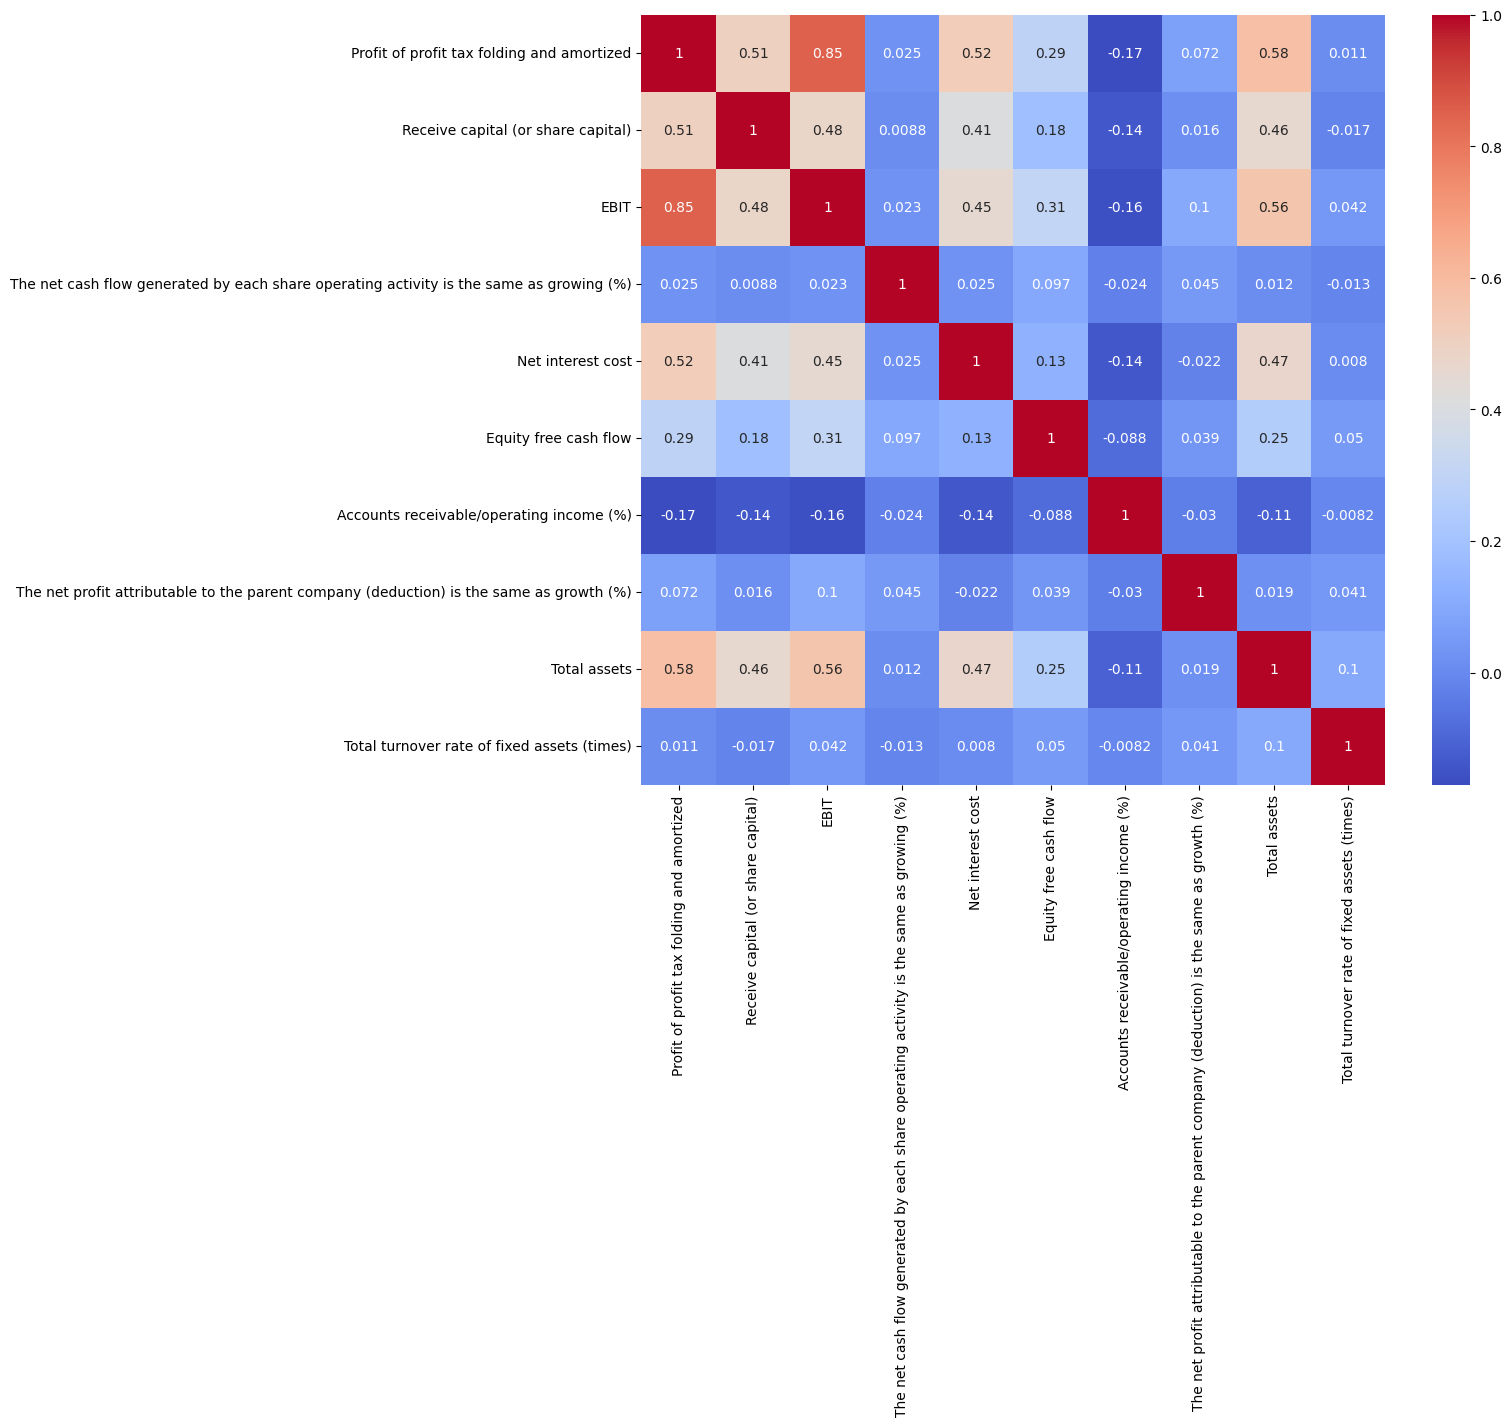

In [5]:
# Get a list of all the column names in the dataframe
all_columns = data_cleaned.columns.tolist()

# # Loop through each column name in the list
# for column in all_columns:
#     # Check if the data type of the column is numeric
#     if not pd.api.types.is_numeric_dtype(data_cleaned[column]):
#         # If the data type is not numeric, delete the column from the dataframe
#         print(f'Deleting column {column} because it is not numeric')
#         data_cleaned.drop(column, axis=1, inplace=True)

# correlation matrix with randomly selected 10 columns
corr = data_cleaned.sample(10, axis=1).corr()

# plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, 
            annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap='coolwarm')
plt.show()


In [8]:
# according to the correlation matrix, select pair of columns with correlation coefficient > 0.8
corr_matrix = data_cleaned.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[('Total fixed assets', 'Fixed asset'),
 ('Interest debt', 'Net debt'),
 ('Interest debt', 'Invest in capital'),
 ('Formal asset', 'The total equity of the owner of the parent company'),
 ('Formal asset', 'Total ownership (or shareholder equity) total'),
 ('retained earnings', 'undistributed profit'),
 ('Net income of business activities',
  'The net profit attributable to shareholders of listed companies after deducting non -recurring profit or loss'),
 ('EBIT', 'Profit of profit tax folding and amortized'),
 ('EBIT', 'Profitable after -tax profit'),
 ('Profit of profit tax folding and amortized',
  'Profitable after -tax profit'),
 ('Earns per share (diluted at the end of the period, yuan/share)',
  'Basic earnings per share'),
 ('Earns per share (diluted at the end of the period, yuan/share)',
  'Business profit per share (yuan/share)'),
 ('Earns per share (diluted at the end of the period, yuan/share)',
  'Before the dividend tax (yuan/share)'),
 ('Basic earnings per share', 'Dilut

#### Data Visualization

#### Feature Selection

To give a quick preview on the company, we manually select five financial factors to perform visualization.

The five financial factors, "Total fixed assets", "Interest debt", "Net debt", "Operating capital", and "Cash and cash equivalent net increase", are crucial in analyzing the situation of high stock dividends (i.e. high ratio of stock dividends or bonus shares). From an economic perspective, these factors reflect a company's financial condition, debt-paying ability, operating capital management, and cash flow situation, all of which are important factors that affect a company's decision to carry out high stock dividends. Below, I will explain the relevance of each factor in detail:

1. **Total Fixed Assets**:
    - Total fixed assets reflect a company's capital investment and asset size. A high amount of fixed assets may indicate that the company has invested a large amount of capital in its business operations. Capital-intensive companies may be more inclined to retain profits to support the maintenance and expansion of their long-term assets, rather than returning them to shareholders through high stock dividends.

2. **Interest Debt**:
    - The level of interest-bearing debt indicates a company's debt level and debt-paying pressure. A high level of interest-bearing debt may mean that the company needs to retain more cash to pay off debt interest, which may limit its ability to carry out high stock dividends.

3. **Net Debt**:
    - Net debt is the difference between a company's total debt and cash and cash equivalents. A higher level of net debt may indicate that the company is under greater pressure to repay debt, which may affect its ability to pay dividends or carry out bonus share issues. 

4. **Operating Capital**:
    - Operating capital is the difference between a company's current assets and current liabilities, and is an important indicator of short-term financial health. Adequate operating capital indicates that the company can meet short-term debt and operational needs. However, too much operating capital may indicate that the company is not effectively using its funds, while tight operating capital may indicate liquidity issues, both of which may affect the company's decision to carry out high stock dividends.

5. **Cash and Cash Equivalent Net Increase**:
    - This indicator measures the increase or decrease in a company's cash and cash equivalents over a certain period of time. Cash flow is the lifeblood of a company's operations, and strong cash flow gives companies greater flexibility when considering shareholder returns (such as high stock dividends). Conversely, companies with tight cash flow may be more conservative in their dividend policies.

In summary, these factors reflect a company's financial condition and operating efficiency from different perspectives, all of which are key factors that affect a company's decision to carry out high stock dividends. By considering these factors comprehensively, we can more fully understand and predict a company's behavior regarding high stock dividends.

In [9]:
selected_factors = [
  'Total fixed assets',
  'Interest debt',
  'Net debt',
  'Operating capital',
  'Cash and cash equivalent net increase'
]


#### Figure Plot

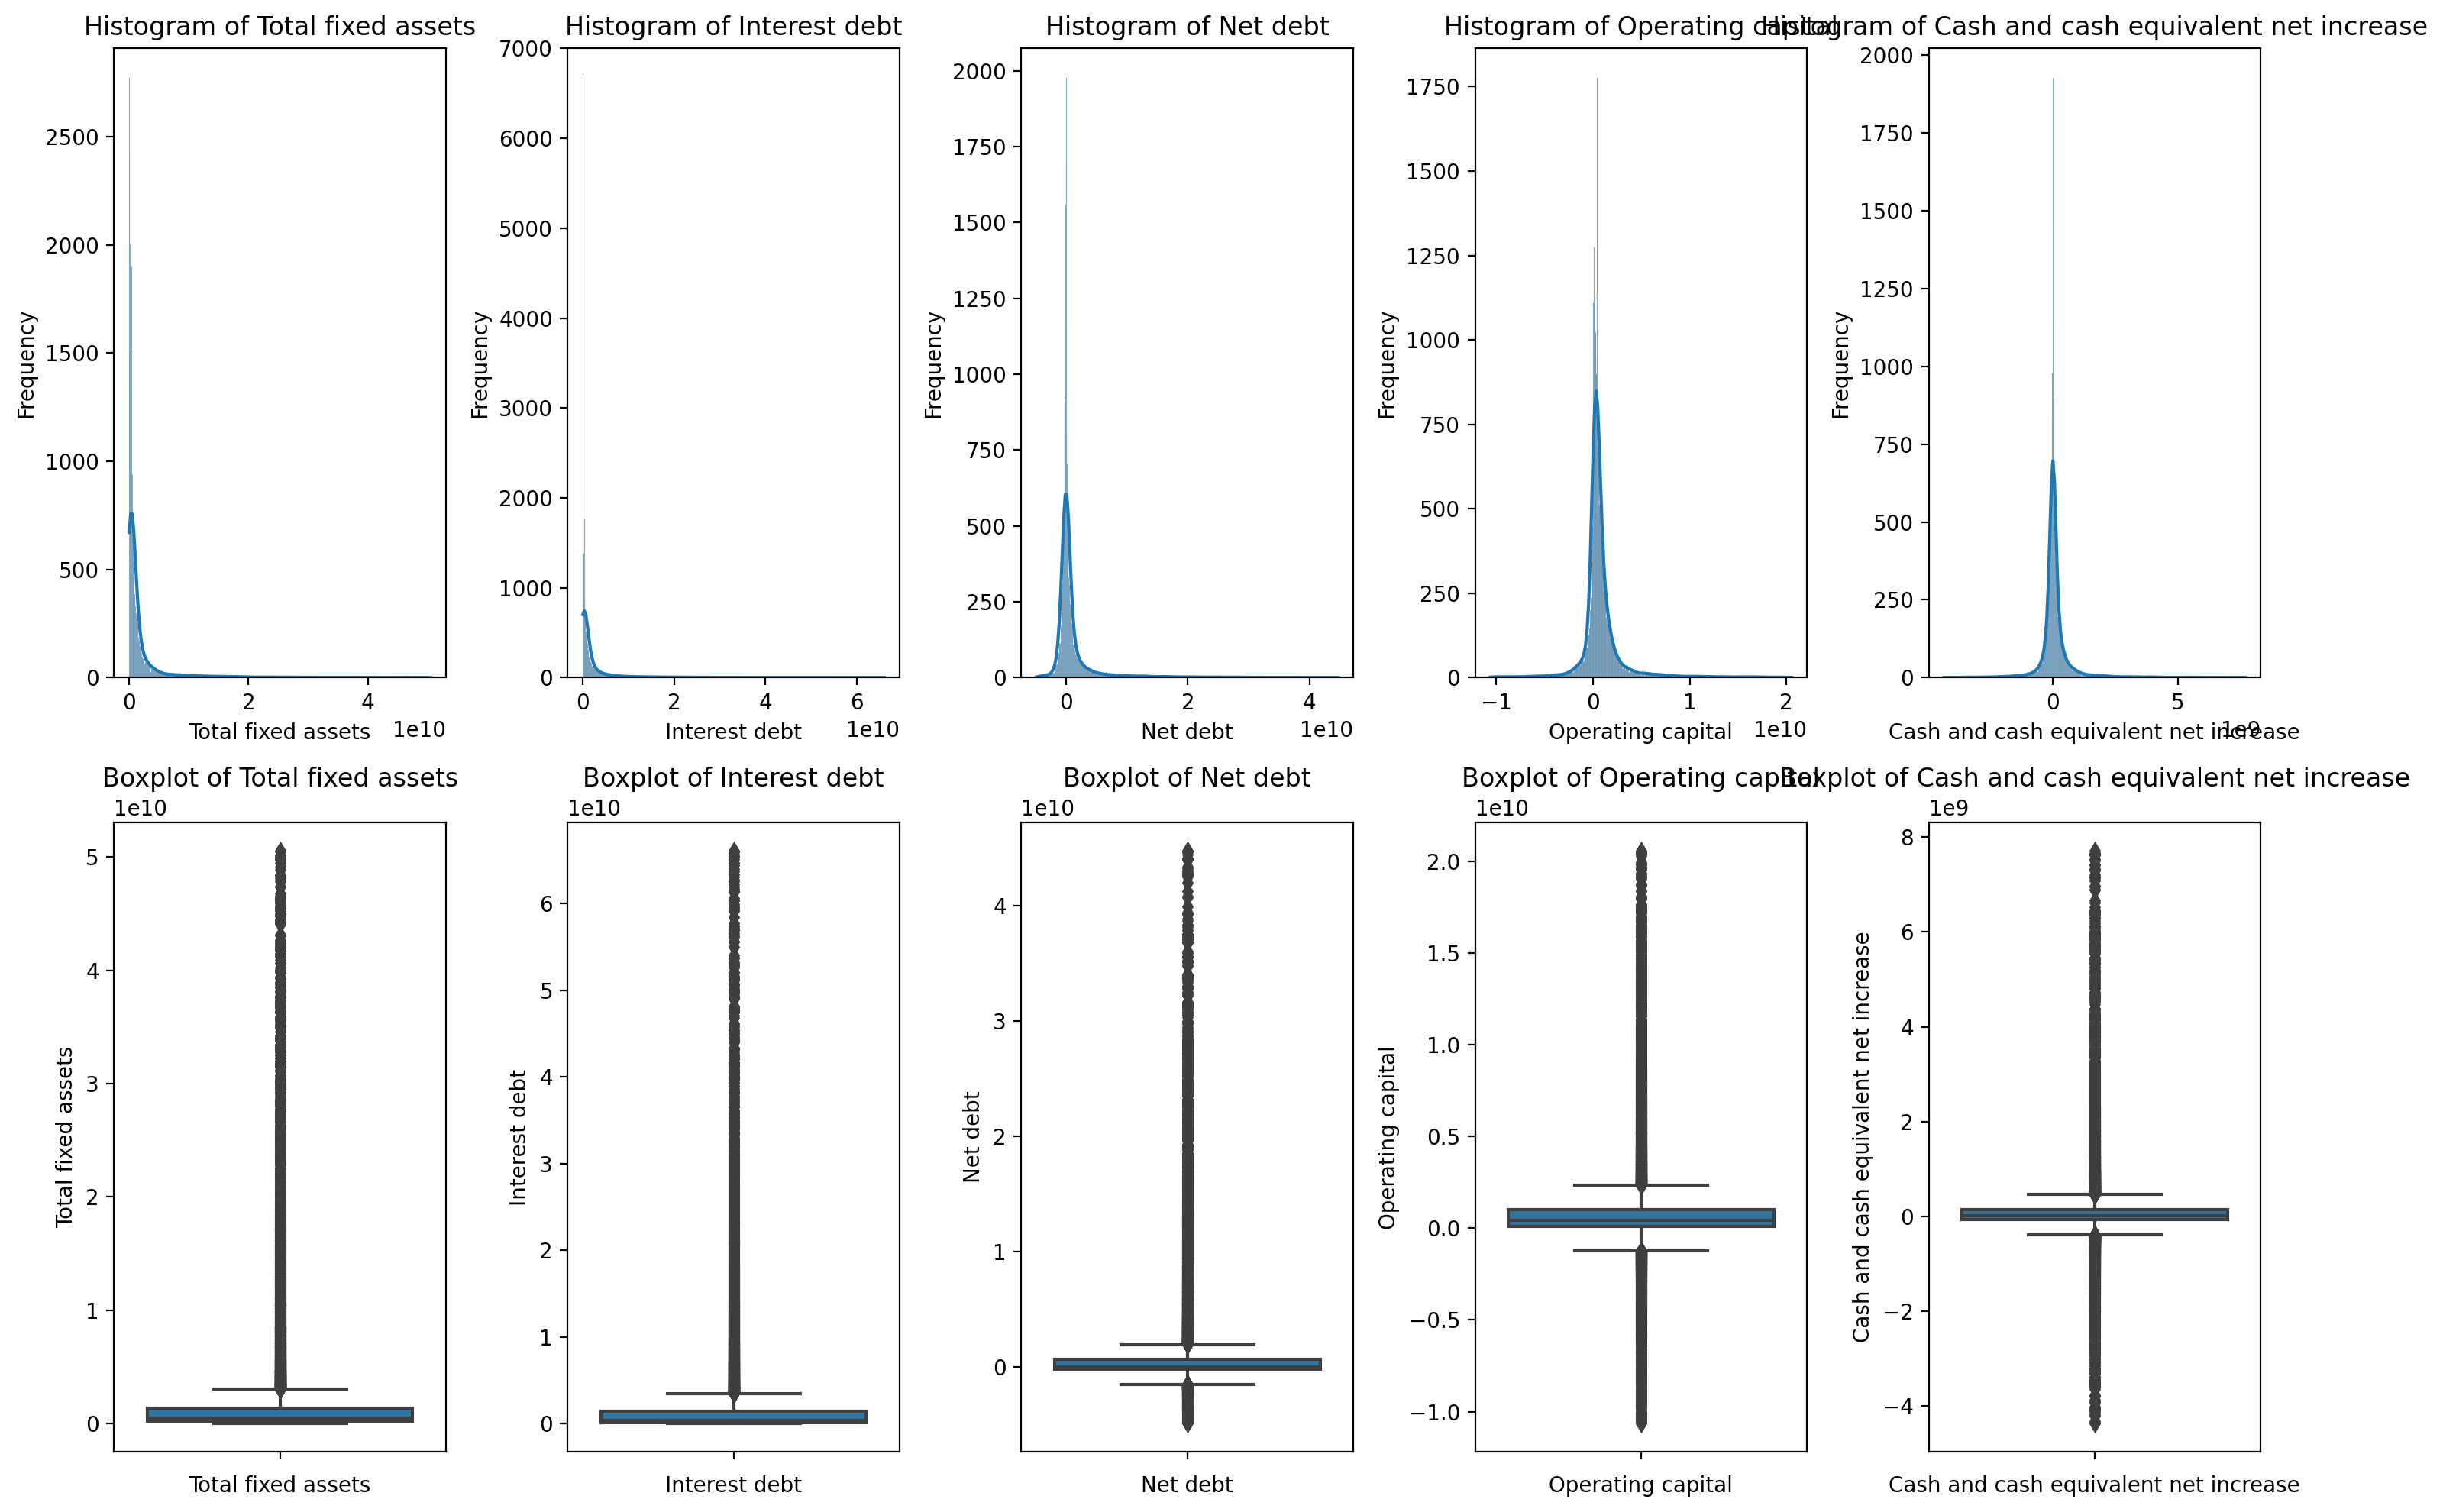

In [10]:
# Plotting histograms and boxplots for the available factors
selected_data = data_cleaned[selected_factors]

# Plotting
plt.figure(figsize=(15, 10), dpi=200)

for i, col in enumerate(selected_data.columns):
    # Histogram
    plt.subplot(2, len(selected_data.columns), i+1)
    sns.histplot(selected_data[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(2, len(selected_data.columns), len(selected_data.columns) + i+1)
    sns.boxplot(y=selected_data[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


#### Figure Explanation


**Histograms:**

1. **Total fixed assets:** The histogram is skewed to the right, with most data points concentrated near zero, suggesting most values in the data set are low with a few large outliers.
2. **Interest debt:** This also shows a right-skewed distribution, similar to total fixed assets, indicating that most companies have low interest debt with some exceptions.
3. **Net debt:** The distribution is right-skewed, meaning that most observations are clustered around lower values with few high-value outliers.
4. **Operating capital:** This histogram appears to be more centrally distributed but still shows a slight right-skewness, with most data points close to zero.
5. **Cash and cash equivalent net increase:** The histogram is quite skewed, with a long tail to the right, indicating that while most changes in cash and cash equivalents are small, there are cases with significant increases.

**Boxplots:**

1. **Total fixed assets:** The boxplot indicates a median near zero with a large number of outliers, which are represented by points above the upper whisker.
2. **Interest debt:** Similar to total fixed assets, the median is close to zero with many high-value outliers.
3. **Net debt:** The boxplot shows a median close to zero, with numerous outliers indicating significant variation in net debt among the sampled entities.
4. **Operating capital:** The median operating capital is around zero, with outliers on both sides, suggesting that while many entities have a balance around zero, there are significant deviations in both directions.
5. **Cash and cash equivalent net increase:** The median is slightly above zero, with many outliers above the upper whisker, showing that there are entities with significant increases in cash and cash equivalents.

**Summary and Conclusion:**

The provided financial metrics are highly right-skewed, indicating that a majority of the entities have low values for these financial items, with a small number of entities having very high values. This pattern is commonly seen in financial data where a few entities hold a majority of wealth or debt. The presence of outliers in all the boxplots indicates that there is considerable variability in each financial metric across the entities. The data suggest a financial landscape where most entities maintain conservative levels on these metrics, while a few have much larger scales of operation or debt.

#### Time Series Analyses

In [95]:
# Extracting the relevant columns for time series analysis
selected_columns = ['Year (end of the year)', 'Total fixed assets', 'Interest debt', 'Net debt', 'Operating capital', 'Cash and cash equivalent net increase', 'Whether to transfer']
time_series_data = data_cleaned[selected_columns]

# Ensuring the data is sorted by year
time_series_data = time_series_data.sort_values(by='Year (end of the year)')

# Displaying the prepared time series data
time_series_data.head()

time_series_data

,Year (end of the year),Total fixed assets,Interest debt,Net debt,Operating capital,Cash and cash equivalent net increase,Whether to transfer
0,1,8.691229e+07,8.271884e+08,3.578747e+08,5.904970e+08,-7.615285e+07,0.0
6405,1,1.251370e+09,1.683189e+09,1.287213e+09,4.120580e+08,1.174824e+08,0.0
20020,1,1.916157e+10,8.987933e+09,2.275379e+09,2.149090e+09,3.255819e+07,0.0
6412,1,1.898165e+09,8.266461e+09,5.564568e+09,2.061338e+09,7.692606e+07,0.0
20013,1,5.176251e+08,4.355553e+08,-1.356295e+08,1.359635e+09,-2.201910e+08,0.0
...,...,...,...,...,...,...,...
4906,7,4.722699e+08,1.058075e+08,1.000392e+08,-2.525003e+08,-1.568900e+07,0.0
10660,7,6.459832e+09,3.531621e+09,-4.600292e+07,-1.155741e+09,5.750998e+07,0.0
21034,7,2.788788e+07,0.000000e+00,-3.954051e+08,7.383697e+08,8.683034e+07,1.0
10009,7,1.942868e+09,1.795202e+09,-1.887844e+07,1.812468e+09,9.496267e+08,0.0


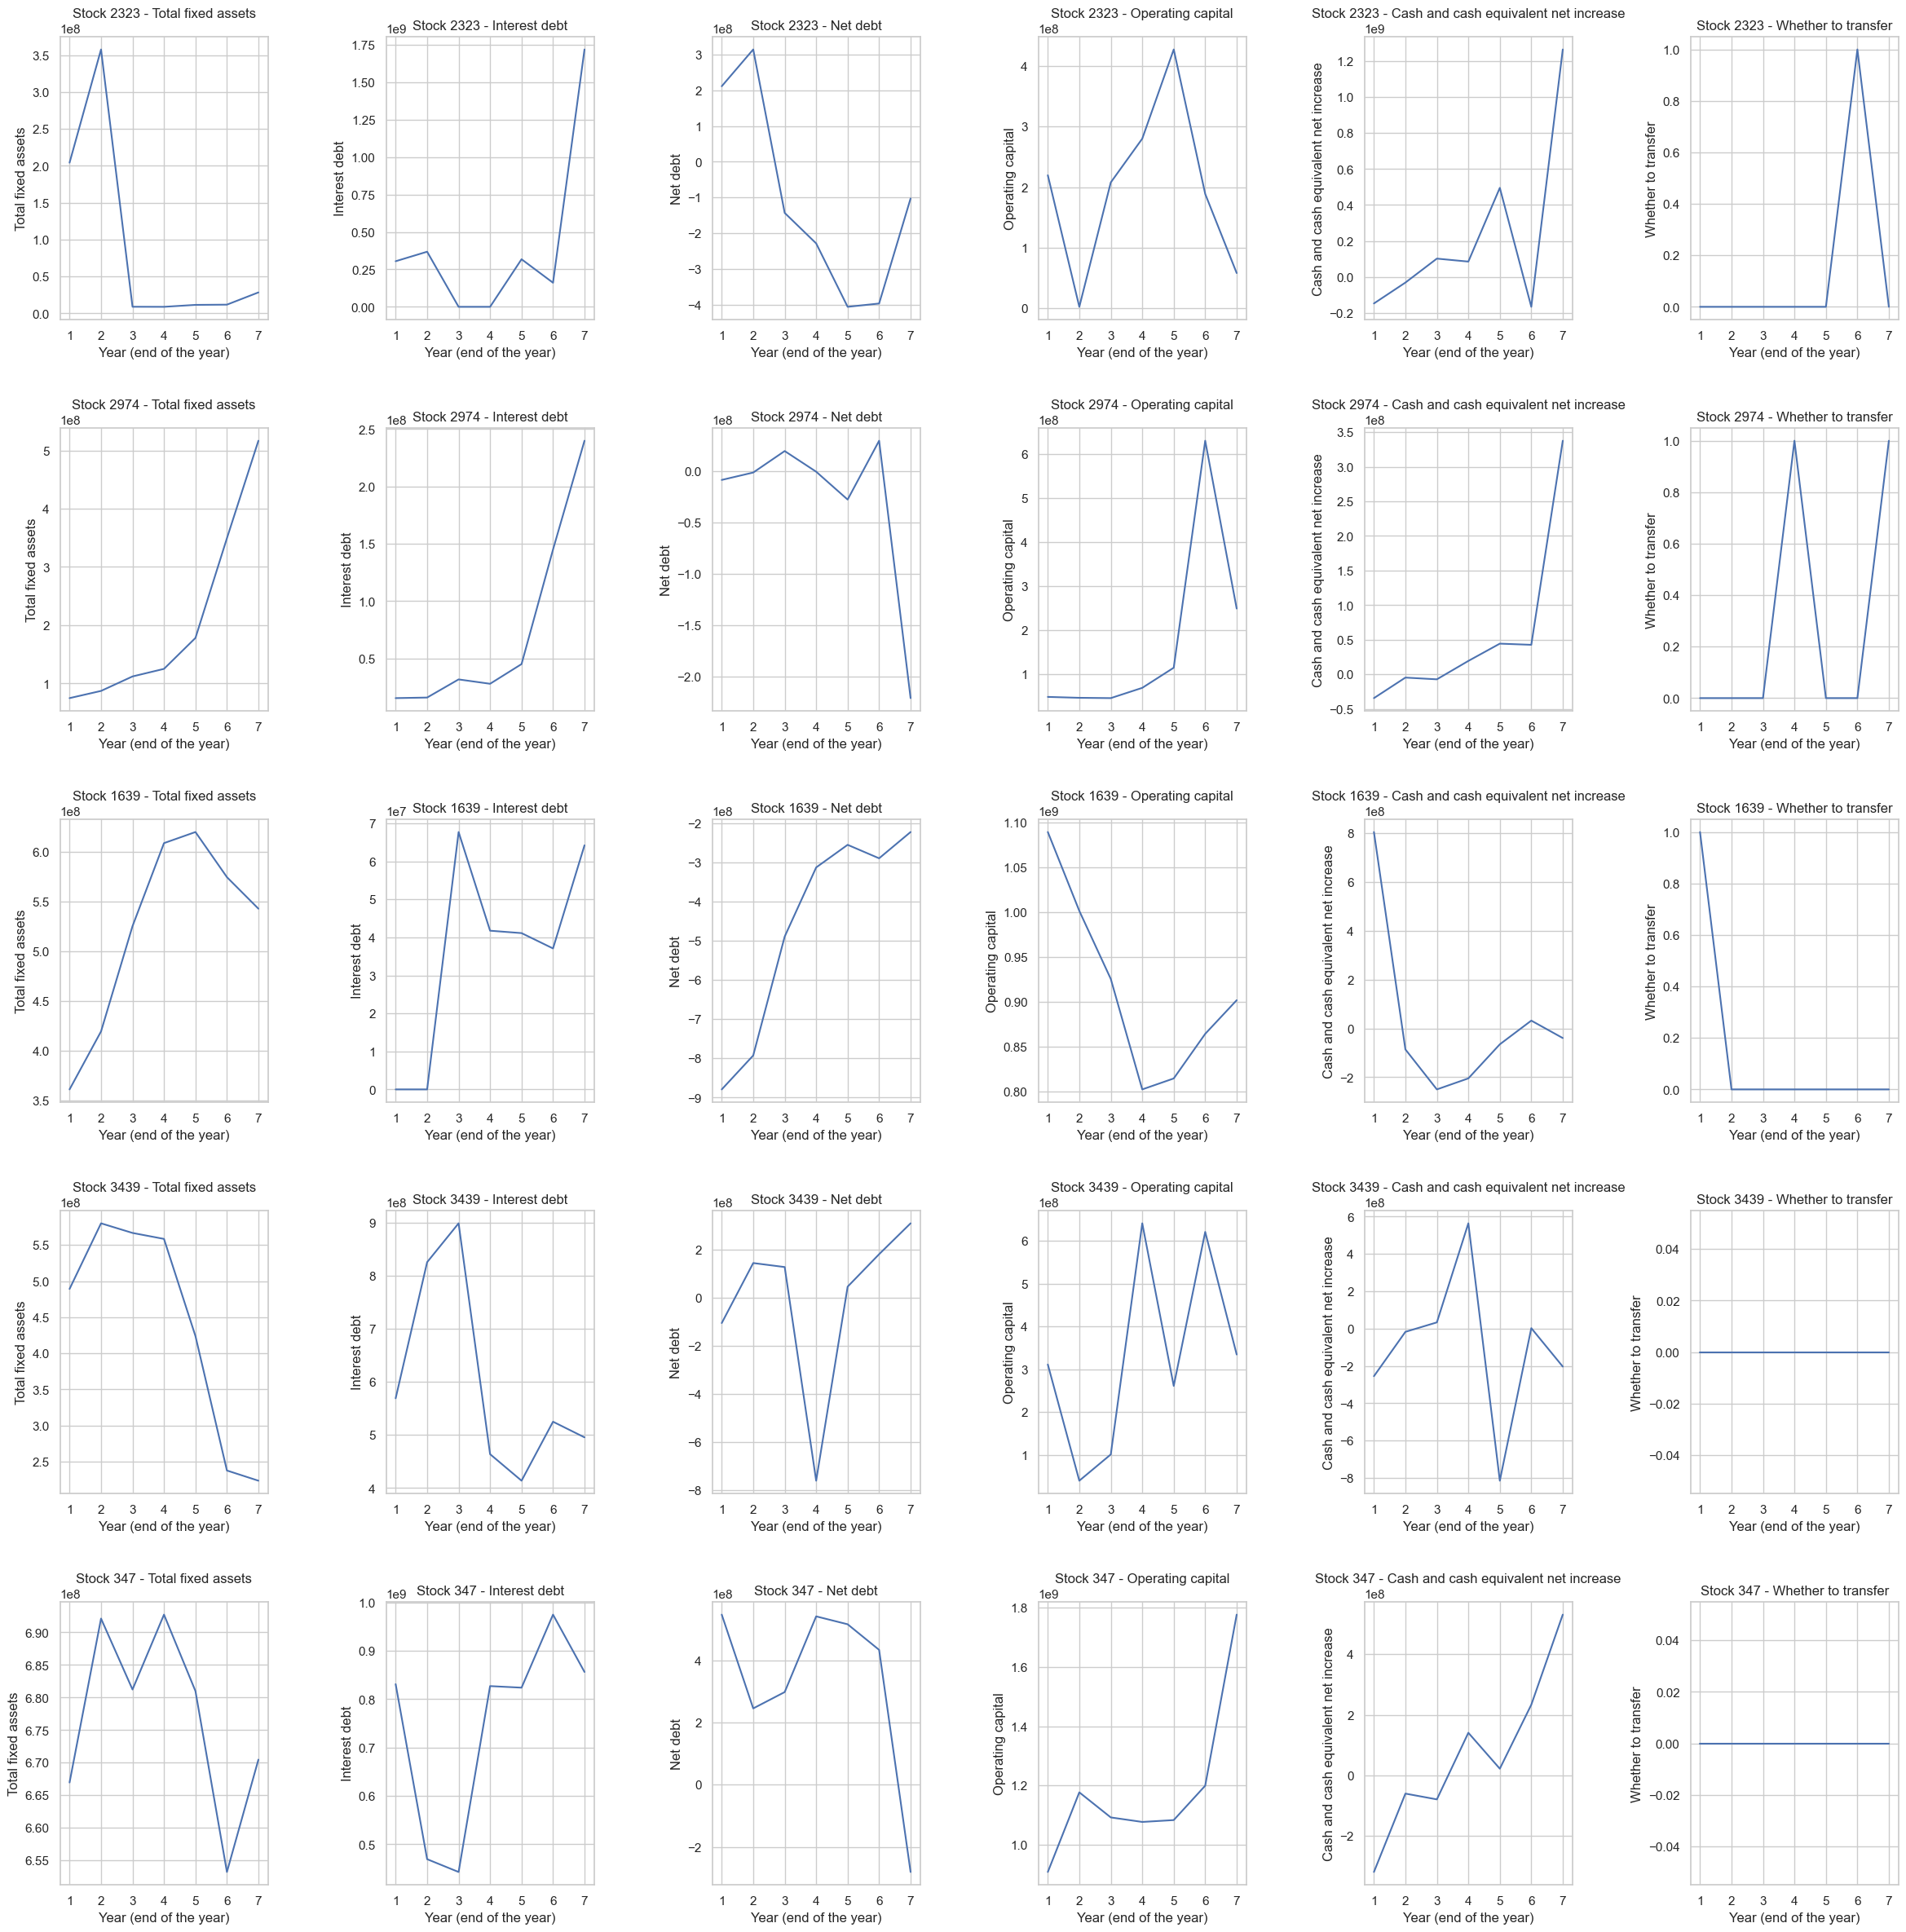

In [97]:
import random

# Number of stocks to analyze (can be changed)
num_stocks_to_analyze = 5

# Randomly select 5 stocks from the dataset
random_stocks = random.sample(data['Stock number'].unique().tolist(), num_stocks_to_analyze)

# Setting up the figure for plotting (5 randomly selected stocks, 5 factors each, so 25 plots)
fig, axes = plt.subplots(nrows=num_stocks_to_analyze, ncols=6, figsize=(25, num_stocks_to_analyze * 5))
fig.tight_layout(pad=6.0)

# Looping through the selected stocks
for i, stock_number in enumerate(random_stocks):
    # Extracting data for the current stock
    stock_data = data[data['Stock number'] == stock_number]

    # Looping through each financial factor
    for j, column in enumerate(selected_columns[1:]):
        sns.lineplot(data=stock_data, x='Year (end of the year)', y=column, ax=axes[i, j])
        axes[i, j].set_title(f'Stock {stock_number} - {column}')

plt.show()


We randomly select 5 stocks among all stocks, and generate a line graph in terms of these 5 factors. For each stock, its own distinct factor value may be fluctuated. Then we will consider all stocks for one speicfic factor.


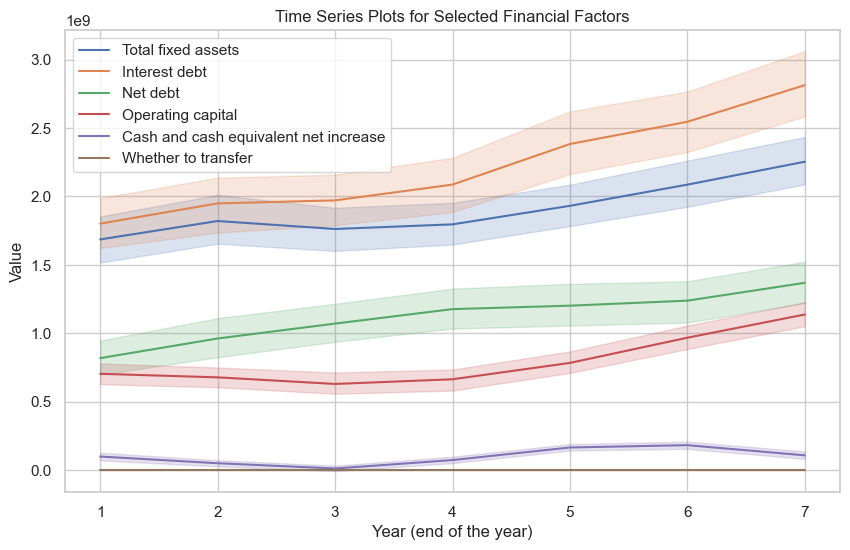

In [98]:
# Setting up the plotting environment
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plotting each time series
for column in selected_columns[1:]:
    sns.lineplot(data=time_series_data, x='Year (end of the year)', y=column, label=column)

plt.title('Time Series Plots for Selected Financial Factors')
plt.ylabel('Value')
plt.xlabel('Year (end of the year)')
plt.legend()
plt.show()

The chart presents the time series of five financial metrics over a period of seven years, assumed to be consecutive from Year 1 to Year 7. Each metric is represented by a different color.

1. **Total fixed assets (Blue Line)**: This metric starts relatively stable, then shows a significant increase between Years 3 and 4, leveling off afterwards. The increase could indicate capital investments or acquisitions.

2. **Interest Debt (Orange Line)**: Exhibits a consistent upward trend, implying that the interest-bearing debt is increasing over time. This could suggest the company is taking on more debt or facing higher interest rates.
 
3. **Net Debt (Green Line)**: Also trends upward, particularly accelerating after Year 3. This could reflect an increasing level of overall indebtedness.
 
4. **Operating Capital (Red Line)**: Gradually increases from Year 1, with the largest growth between Years 4 and 5, and then the rate of increase slows. This might be due to improved working capital management or growing business operations.
 
5. **Cash and Cash Equivalent Net Increase (Purple Line)**: Shows significant volatility with a notable dip in Year 2 followed by year-on-year increases. This volatility warrants further investigation to understand underlying causes, such as market events or changes in company policies.

**Summary and Conclusion:**

The shaded areas around each line represent confidence intervals or the range of error, indicating uncertainty in the data. Wider shaded areas suggest greater variability among data points for that year.All metrics display an upward trend, possibly indicating that the group's asset base is growing, but also accompanied by an increase in debt.The fluctuations in net increase of cash and equivalents might require additional analysis to discern the reasons behind these changes, such as specific market events or changes in corporate strategies.


## Exploratory Data Analysis

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

data_for_fixed_effects = data_cleaned.copy()
data_for_fixed_effects.set_index(['Stock number', 'Year (end of the year)'], inplace=True)

# clarify the exogenous variables, aka the independent variables
exog = sm.tools.tools.add_constant(data_for_fixed_effects[selected_factors])
dep_var = 'Whether to transfer'

vif = [variance_inflation_factor(exog.values, exog.columns.get_loc(i)) for i in exog.columns if i != 'const']
tol = [1./variance_inflation_factor(exog.values, exog.columns.get_loc(i)) for i in exog.columns if i != 'const']
print('vif', vif)
print('tol', tol)

# construct the panel data regression model
mod = PanelOLS(data_for_fixed_effects[dep_var], exog, entity_effects=True, time_effects=True)

# fit the model
fe_res = mod.fit(cov_type='clustered', cluster_entity=True)
print(fe_res)

del data_for_fixed_effects


vif [1.6495951440973369, 3.6813738111441072, 3.4875802782103023, 1.0945732507260044, 1.0600039963809509]
tol [0.606209349959746, 0.2716377231165279, 0.28673175102170356, 0.9135980614698228, 0.9433926696636846]
                           PanelOLS Estimation Summary                           
Dep. Variable:     Whether to transfer   R-squared:                        0.0050
Estimator:                    PanelOLS   R-squared (Between):              0.0279
No. Observations:                22541   R-squared (Within):               0.0053
Date:                 Mon, Nov 13 2023   R-squared (Overall):              0.0104
Time:                         21:04:42   Log-likelihood                   -5319.0
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      19.279
Entities:                         3396   P-value                           0.0000
Avg Obs:                        6.6375   Distributio

## Prediction

In [5]:
data_cleaned

,Stock number,Year (end of the year),Total fixed assets,Interest -free liability,Interest -free non -current liabilities,Interest liabilities,Interest debt,Net debt,Formal asset,Operating capital,...,"Dividement, profit, or payment of interest payment cash",Payment other cash related to fundraising activities,Cash outflow of fundraising activities,Net cash flow from financing activities,effect of the changes of the exchange rate on cash and the equivalents,Cash and cash equivalent net increase,Add: At the beginning of the period of cash and cash equivalent,At the end of the period of cash and cash equivalent,Turn per share,Whether to transfer
0,1,1,8.691229e+07,1.422495e+09,1.600192e+08,8.198551e+08,8.271884e+08,3.578747e+08,8.929308e+08,5.904970e+08,...,4.396870e+07,1396200.00,3.243249e+08,2.881703e+08,-217885.53,-7.615285e+07,5.454666e+08,4.693137e+08,0.13,0.0
1,1,2,7.887817e+07,1.903724e+09,1.487364e+08,3.749099e+08,3.942266e+08,-4.034978e+08,1.190906e+09,9.114353e+08,...,4.891714e+07,1584500.00,6.694635e+08,-4.834635e+08,1103.36,3.284106e+08,4.693137e+08,7.977243e+08,0.13,0.0
2,1,3,7.530102e+07,1.447218e+09,1.418316e+08,3.643167e+08,4.805600e+08,-4.966118e+08,1.501162e+09,1.333070e+09,...,2.337307e+07,1677492.00,3.973809e+08,6.386246e+07,-801465.87,1.794475e+08,7.977243e+08,9.771718e+08,0.25,0.0
3,1,4,6.406923e+07,1.388840e+09,1.367301e+08,1.050000e+08,2.826134e+08,-5.263500e+08,1.755344e+09,1.697810e+09,...,1.787611e+08,17131885.01,6.930777e+08,-3.767077e+08,-1093973.32,-1.682084e+08,9.771718e+08,8.089634e+08,0.22,0.0
4,1,5,8.592952e+07,1.870206e+09,1.347049e+08,1.292434e+08,2.740834e+08,-6.716566e+08,1.764907e+09,1.665822e+09,...,1.492891e+08,104500.00,3.743936e+08,-1.579236e+08,2757607.83,1.243744e+08,8.089634e+08,9.333378e+08,0.08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24257,3466,3,1.749089e+08,9.162246e+07,1.583035e+07,6.589091e+07,6.589091e+07,9.880669e+06,2.252468e+08,6.080053e+07,...,2.466474e+07,17131885.01,5.466474e+07,5.335261e+06,-8344.27,1.811266e+07,3.400758e+07,5.212024e+07,0.13,0.0
24258,3466,4,1.674375e+08,1.017815e+08,1.360359e+07,2.314488e+07,2.314488e+07,-1.139792e+08,3.873122e+08,2.294332e+08,...,1.615895e+07,17131885.01,9.615895e+07,6.047802e+07,-8344.27,7.917448e+07,5.212024e+07,1.312947e+08,0.20,0.0
24259,3466,5,1.627839e+08,8.110693e+07,1.326047e+07,1.415562e+07,1.415562e+07,-1.464317e+06,3.651500e+08,2.133559e+08,...,1.562120e+07,17131885.01,1.562120e+07,-1.110120e+07,-8344.27,-1.178085e+08,1.312947e+08,1.348623e+07,0.11,0.0
24260,3466,6,1.897513e+08,1.432359e+08,1.203168e+07,2.974001e+07,2.974001e+07,-4.736971e+07,3.793057e+08,2.000272e+08,...,8.697808e+06,17131885.01,8.697808e+06,-6.697808e+06,-8344.27,5.956293e+07,1.348623e+07,7.304916e+07,0.11,0.0


### Data Split

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,confusion_matrix,accuracy_score

data_for_pred = data_cleaned.copy()
data_for_pred = data_for_pred.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

stock_set = data_cleaned.loc[:, 'Stock number'].value_counts().index.tolist()

# split the data into training and validation sets according to the stock number
train_index, validate_index = train_test_split(stock_set, test_size=0.2, random_state=88)

train = data_for_pred[data_for_pred['Stock_number'].isin(train_index)].reset_index(drop=True)
validate = data_for_pred[data_for_pred['Stock_number'].isin(validate_index)].reset_index(drop=True)

train_x = train.drop(columns=['Whether_to_transfer'])
train_y = train['Whether_to_transfer']
validate_x = validate.drop(columns=['Whether_to_transfer'])
validate_y = validate['Whether_to_transfer']

train_x.drop(columns=['Stock_number', 'Year_end_of_the_year_','Accounting_Standards','Currency_code'], inplace=True)
validate_x.drop(columns=['Stock_number', 'Year_end_of_the_year_','Accounting_Standards','Currency_code'], inplace=True)

train = pd.concat([train_x, train_y], axis=1)
train

,Total_fixed_assets,Interest_free_liability,Interest_free_non_current_liabilities,Interest_liabilities,Interest_debt,Net_debt,Formal_asset,Operating_capital,Net_operating_capital,Invest_in_capital,...,Dividement_profit_or_payment_of_interest_payment_cash,Payment_other_cash_related_to_fundraising_activities,Cash_outflow_of_fundraising_activities,Net_cash_flow_from_financing_activities,effect_of_the_changes_of_the_exchange_rate_on_cash_and_the_equivalents,Cash_and_cash_equivalent_net_increase,Add_At_the_beginning_of_the_period_of_cash_and_cash_equivalent,At_the_end_of_the_period_of_cash_and_cash_equivalent,Turn_per_share,Whether_to_transfer
0,8.691229e+07,1.422495e+09,1.600192e+08,8.198551e+08,8.271884e+08,3.578747e+08,8.929308e+08,5.904970e+08,9.410384e+08,1.969511e+09,...,4.396870e+07,1396200.00,3.243249e+08,2.881703e+08,-217885.53,-7.615285e+07,5.454666e+08,4.693137e+08,0.13,0.0
1,7.887817e+07,1.903724e+09,1.487364e+08,3.749099e+08,3.942266e+08,-4.034978e+08,1.190906e+09,9.114353e+08,4.886209e+08,1.898245e+09,...,4.891714e+07,1584500.00,6.694635e+08,-4.834635e+08,1103.36,3.284106e+08,4.693137e+08,7.977243e+08,0.13,0.0
2,7.530102e+07,1.447218e+09,1.418316e+08,3.643167e+08,4.805600e+08,-4.966118e+08,1.501162e+09,1.333070e+09,7.202144e+08,2.284203e+09,...,2.337307e+07,1677492.00,3.973809e+08,6.386246e+07,-801465.87,1.794475e+08,7.977243e+08,9.771718e+08,0.25,0.0
3,6.406923e+07,1.388840e+09,1.367301e+08,1.050000e+08,2.826134e+08,-5.263500e+08,1.755344e+09,1.697810e+09,9.938462e+08,2.357718e+09,...,1.787611e+08,17131885.01,6.930777e+08,-3.767077e+08,-1093973.32,-1.682084e+08,9.771718e+08,8.089634e+08,0.22,0.0
4,8.592952e+07,1.870206e+09,1.347049e+08,1.292434e+08,2.740834e+08,-6.716566e+08,1.764907e+09,1.665822e+09,8.493254e+08,2.374852e+09,...,1.492891e+08,104500.00,3.743936e+08,-1.579236e+08,2757607.83,1.243744e+08,8.089634e+08,9.333378e+08,0.08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17992,1.749089e+08,9.162246e+07,1.583035e+07,6.589091e+07,6.589091e+07,9.880669e+06,2.252468e+08,6.080053e+07,7.068119e+07,3.564681e+08,...,2.466474e+07,17131885.01,5.466474e+07,5.335261e+06,-8344.27,1.811266e+07,3.400758e+07,5.212024e+07,0.13,0.0
17993,1.674375e+08,1.017815e+08,1.360359e+07,2.314488e+07,2.314488e+07,-1.139792e+08,3.873122e+08,2.294332e+08,1.154540e+08,4.739910e+08,...,1.615895e+07,17131885.01,9.615895e+07,6.047802e+07,-8344.27,7.917448e+07,5.212024e+07,1.312947e+08,0.20,0.0
17994,1.627839e+08,8.110693e+07,1.326047e+07,1.415562e+07,1.415562e+07,-1.464317e+06,3.651500e+08,2.133559e+08,2.118915e+08,4.750184e+08,...,1.562120e+07,17131885.01,1.562120e+07,-1.110120e+07,-8344.27,-1.178085e+08,1.312947e+08,1.348623e+07,0.11,0.0
17995,1.897513e+08,1.432359e+08,1.203168e+07,2.974001e+07,2.974001e+07,-4.736971e+07,3.793057e+08,2.000272e+08,1.526575e+08,5.009421e+08,...,8.697808e+06,17131885.01,8.697808e+06,-6.697808e+06,-8344.27,5.956293e+07,1.348623e+07,7.304916e+07,0.11,0.0


### Logistics Regression Prediction

In [7]:
# run a basic linear regression model to predict the probability of transfer
import sklearn.linear_model as lm

# define the model
model = lm.LogisticRegression()

# fit the model
model.fit(train_x, train_y)

# predict the probability of transfer
pred_y = model.predict_proba(validate_x)[:, 1]

# convert the probability to binary labels
pred_y_label = np.where(pred_y >= 0.5 , 1, 0)

# calculate the confusion matrix
print(confusion_matrix(validate_y, pred_y_label))

# calculate the accuracy
print(precision_score(validate_y, pred_y_label))


[[3880   47]
 [ 557   60]]
0.5607476635514018


#### Confusion Matrix

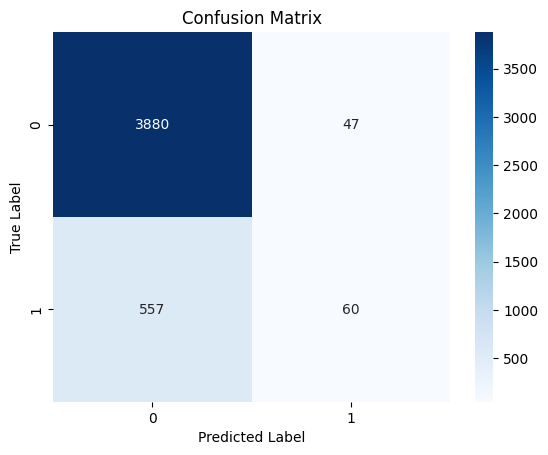

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(validate_y, pred_y_label)

# Plot confusion matrix
sns.heatmap(cm, annot = True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


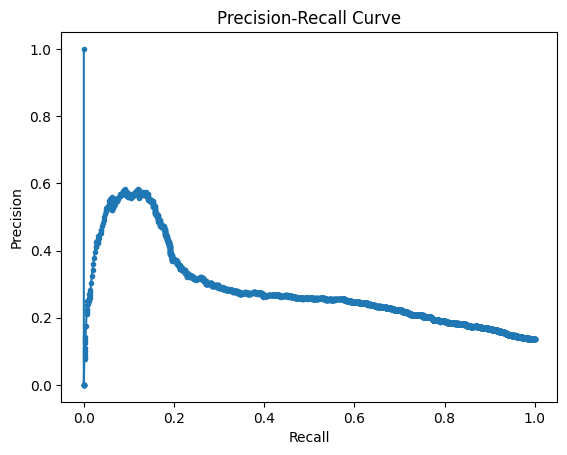

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(validate_y, pred_y)

# Plot Precision-Recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()



#### ROC curve

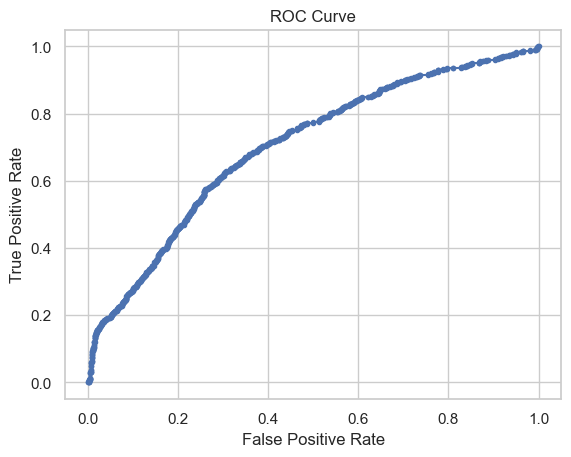

In [99]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(validate_y, pred_y)

# Plot ROC curve
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


#### Coefficient

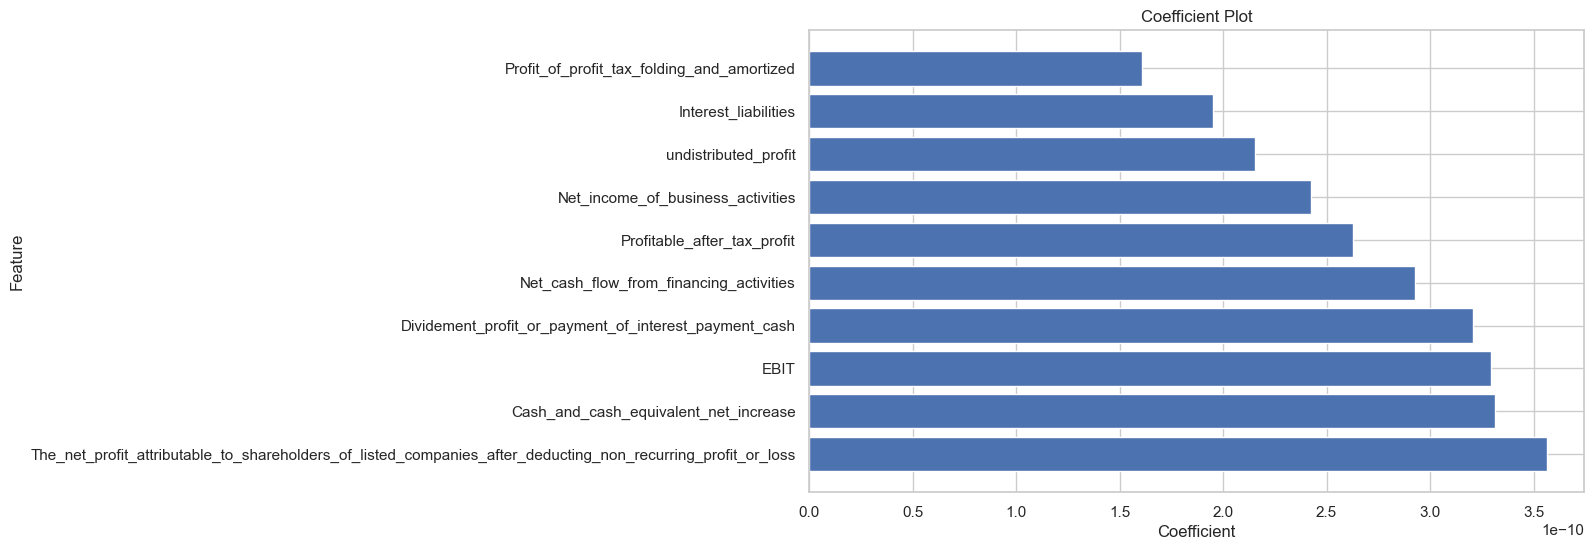

In [103]:
# Coefficient plot of the most 10 important features
impotance = pd.DataFrame({'feature': train_x.columns, 'importance': model.coef_[0]})
impotance = impotance.sort_values(by='importance', ascending=False).reset_index(drop=True)
impotance = impotance.head(10)

plt.figure(figsize=(10, 6))
plt.barh(impotance['feature'], impotance['importance'])
plt.title('Coefficient Plot')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()


### LightGBM + TPE

In [7]:
import lightgbm as lgb
from hyperopt import hp, fmin, tpe


In [32]:
def params_append(params):
    """
    :param params: lgb parameter dictionary
    :return params: lgb parameter dictionary after revision
    """
    params['feature_pre_filter'] = False
    params['boosting'] = 'dart'
    params['objective'] = 'binary'
    # metrics for this classfication task
    params['metric'] = 'binary_logloss'
    params['bagging_seed'] = 2022
    return params

In [33]:
def param_hyperopt(train):
    """
    hyperparameter optimization
    :param train: training data
    :return params_best: the best parameters of the model
    """
    
    label = 'Whether_to_transfer'
    features = train.columns.tolist()
    features.remove('Whether_to_transfer')

    train_data = lgb.Dataset(train[features], train[label])

    def hyperopt_objective(params):
        """
        loss evaluation function
        :param params:
        :return: loss binary_logloss
        """
        params = params_append(params)
        # print(params)

        # cross validation
        res = lgb.cv(params, train_data, 1000,
                     nfold=5,
                     stratified=False,
                     shuffle=True,
                    #  show_stdv=False,
                     seed=2022)
        return min(res['valid binary_logloss-mean'])  # res是个字典

    # the parameter space to be searched
    params_space = {
        'learning_rate': hp.uniform('learning_rate', 1e-2, 5e-1),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
        'num_leaves': hp.choice('num_leaves', list(range(20, 300, 10))),
        'reg_alpha': hp.randint('reg_alpha', 0, 10),
        # 'reg_lambda': hp.uniform('reg_lambda', 0, 10),
        'bagging_freq': hp.randint('bagging_freq', 1, 10),
        'min_child_samples': hp.choice('min_child_samples', list(range(1, 30, 5))),
        'lambda_l1': hp.uniform('lambda_l1', 0, 10),
        'lambda_l2': hp.uniform('lambda_l2', 0, 10),
        'verbose': -1
    }

    # TPE algorithm for hyperparameter optimization
    params_best = fmin(
        hyperopt_objective,
        space=params_space,
        algo=tpe.suggest,
        max_evals=30,
        rstate=np.random.default_rng(2022)
    )

    return params_best

In [ ]:
best_params = param_hyperopt(train)

In [36]:
best_params = params_append(best_params)

label = 'Whether_to_transfer'
features = train.columns.tolist()
features.remove('Whether_to_transfer')

bst = lgb.train(best_params, lgb.Dataset(train[features], train[label]), 1000)


[LightGBM] [Warning] lambda_l1 is set=0.08097353216060554, reg_alpha=3 will be ignored. Current value: lambda_l1=0.08097353216060554
[LightGBM] [Warning] lambda_l1 is set=0.08097353216060554, reg_alpha=3 will be ignored. Current value: lambda_l1=0.08097353216060554
[LightGBM] [Info] Number of positive: 2544, number of negative: 15453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58952
[LightGBM] [Info] Number of data points in the train set: 17997, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.141357 -> initscore=-1.804066
[LightGBM] [Info] Start training from score -1.804066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

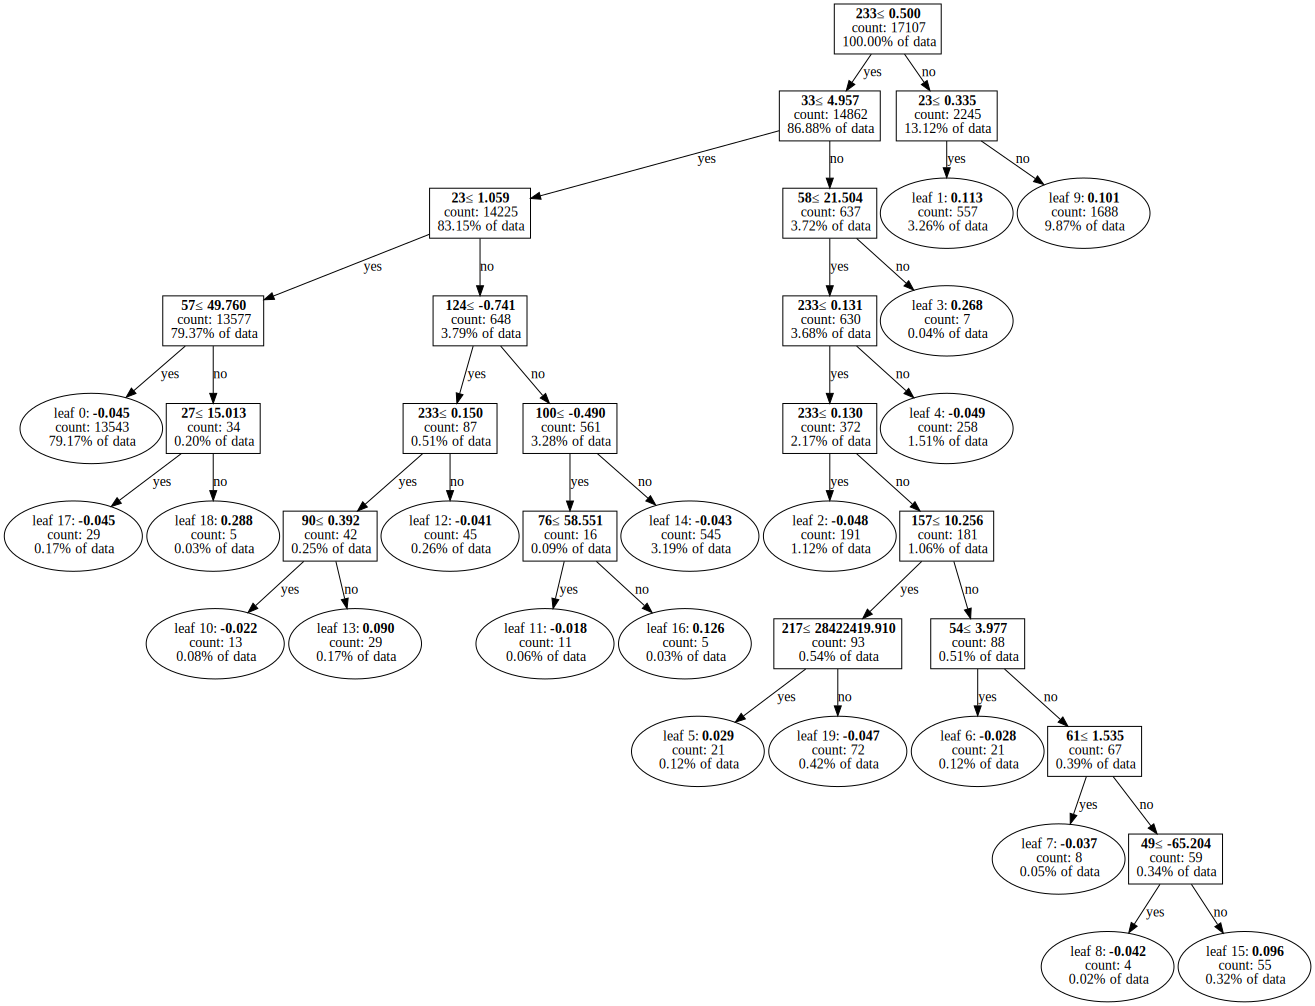

In [37]:
# draw a tree diagram and vertically display the tree structure
lgb.create_tree_digraph(bst, tree_index=2, show_info=['internal_count', 'leaf_count', 'data_percentage'], orientation='vertical', max_category_values=4)




In [12]:
pred_y = bst.predict(validate_x)

pred_y_label = np.where(pred_y >= 0.50, 1, 0)

In [13]:
confusion_matrix(validate_y,pred_y_label)


array([[3923,    4],
       [  18,  599]], dtype=int64)

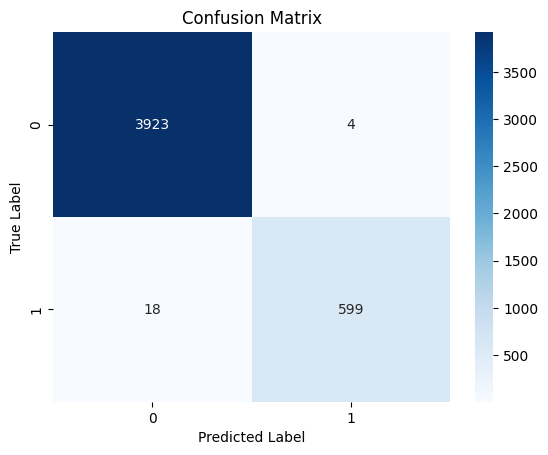

In [29]:
# draw the confusion matrix
cm = confusion_matrix(validate_y, pred_y_label, labels=
                      [0, 1])
cm = pd.DataFrame(cm)
sns.heatmap(cm, annot = True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


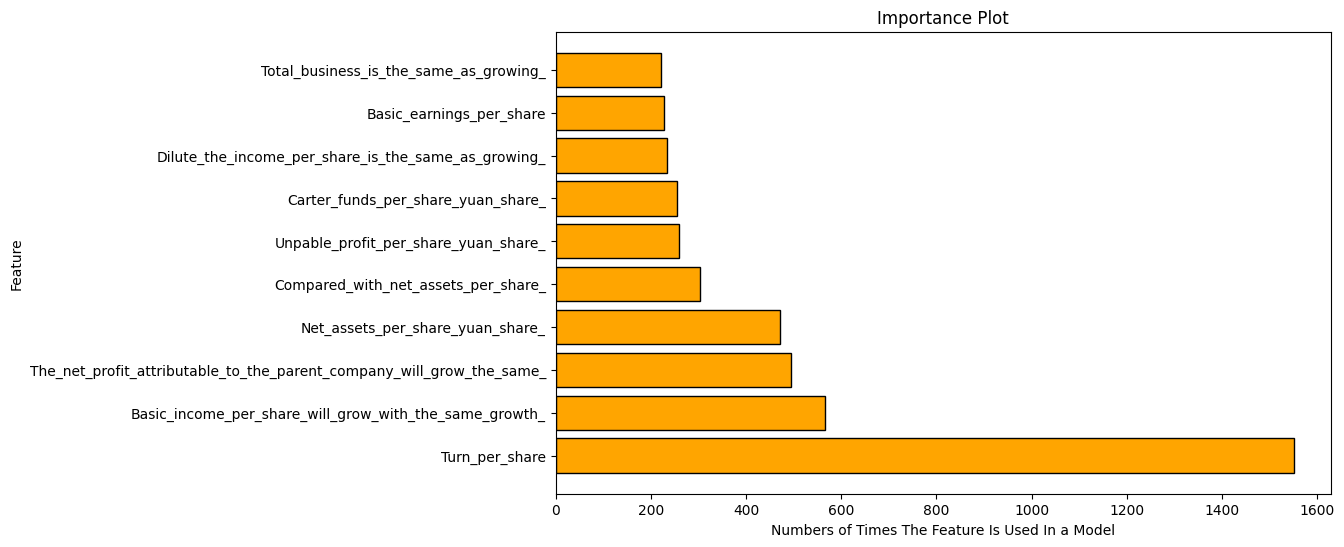

In [37]:
# find the most important ten features
impotance = pd.DataFrame({'feature': features, 'importance': bst.feature_importance('split')})
impotance = impotance.sort_values(by='importance', ascending=False).reset_index(drop=True)
impotance = impotance.head(10)
# plot the numbers of times the feature is used in a model plot, change a better color scheme
plt.figure(figsize=(10, 6))
plt.barh(impotance['feature'], impotance['importance'], color='orange', edgecolor='black')
plt.title('Importance Plot')
plt.xlabel('Numbers of Times The Feature Is Used In a Model')
plt.ylabel('Feature')
plt.show()

In [34]:
impotance

,feature,importance
0,Turn_per_share,1551
1,Basic_income_per_share_will_grow_with_the_same...,566
2,The_net_profit_attributable_to_the_parent_comp...,495
3,Net_assets_per_share_yuan_share_,472
4,Compared_with_net_assets_per_share_,304
5,Unpable_profit_per_share_yuan_share_,259
6,Carter_funds_per_share_yuan_share_,256
7,Dilute_the_income_per_share_is_the_same_as_gro...,234
8,Basic_earnings_per_share,228
9,Total_business_is_the_same_as_growing_,222


In [14]:
print(precision_score(validate_y,pred_y_label), accuracy_score(validate_y,pred_y_label))

0.9933665008291874 0.9951584507042254


### XGBoost + Bayes

In [20]:
import xgboost as xgb
from bayes_opt import BayesianOptimization

def params_append(params):
    """
    :param params:
    :return:
    """
    params['booster'] = 'dart'
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = ['auc', 'logloss']
    # params['eval_metric'] = 'auc'
    params["min_child_weight"] = int(params["min_child_weight"])
    params['max_depth'] = int(params['max_depth'])
    return params


def param_beyesian(train_x, train_y):
    # train_x,validate_x,train_y,validate_y = train_test_split(train,y,test_size=0.2,random_state=0)
    train_data = xgb.DMatrix(train_x, train_y, silent=True)

    def xgb_cv(colsample_bytree, subsample, min_child_weight, max_depth,
               reg_alpha, eta,
               reg_lambda):

        params = {'objective': 'binary:logistic',
                  'eval_metric': 'auc'}
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['subsample'] = max(min(subsample, 1), 0)
        params["min_child_weight"] = int(min_child_weight)
        params['max_depth'] = int(max_depth)
        params['eta'] = float(eta)
        params['reg_alpha'] = max(reg_alpha, 0)
        params['reg_lambda'] = max(reg_lambda, 0)
        # print(params)
        cv_result = xgb.cv(params, train_data,
                           num_boost_round=1000,
                           nfold=5, seed=2,
                           stratified=False,
                           shuffle=True,
                           early_stopping_rounds=30,
                           verbose_eval=False)
        return max(cv_result['test-auc-mean'])

    # the parameter space to be searched
    xgb_bo = BayesianOptimization(
        xgb_cv,
        {'colsample_bytree': (0.1, 1),
         'subsample': (0.1, 1),
         'min_child_weight': (1, 30),
         'max_depth': (3, 15),
         'reg_alpha': (0, 5),
         'eta': (0.02, 0.2),
         'reg_lambda': (0, 5)}
    )
    xgb_bo.maximize(init_points = 5, n_iter = 10)
    print(xgb_bo.max['target'], xgb_bo.max['params'])
    return xgb_bo.max['params']

In [18]:
params_best = param_beyesian(train_x, train_y)

|   iter    |  target   | colsam... |    eta    | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9989    | 0.9354    | 0.08127   | 11.53     | 8.847     | 2.07      | 1.303     | 0.4006    |
| 2         | 0.9993    | 0.3694    | 0.06009   | 8.676     | 4.117     | 0.773     | 4.396     | 0.9982    |
| 3         | 0.9992    | 0.4959    | 0.113     | 5.76      | 12.44     | 0.2795    | 1.466     | 0.8549    |
| 4         | 0.9968    | 0.7333    | 0.1049    | 6.113     | 25.78     | 1.313     | 0.2022    | 0.2601    |
| 5         | 0.9982    | 0.87      | 0.06263   | 11.14     | 10.35     | 2.246     | 2.737     | 0.2499    |
| 6         | 0.9989    | 0.9563    | 0.03296   | 11.14     | 9.055     | 2.196     | 1.182     | 0.3982    |
| 7         | 0.9992    | 0.8467    | 0.02163   | 5.936     | 6.279     | 1.182     | 0.0       | 1.0       |
| 8       

In [22]:
# params = params_append(params_best)
params = params_append({'colsample_bytree': 0.5838714878037353, 'eta': 0.04392105129157185, 'max_depth': 14.381210620883715, 
                        'min_child_weight': 1.1971922778121291, 'reg_alpha': 0.1395182555501795, 'reg_lambda': 4.843525368171262, 
                        'subsample': 0.6751565661667369})

train_part_x,eval_part_x,train_part_y,eval_part_y = train_test_split(train_x,train_y,test_size=0.2,random_state=0)

train_part = xgb.DMatrix(train_x, train_y, silent=True)
eval_part = xgb.DMatrix(eval_part_x, eval_part_y, silent=True)


ESR = 10
NBR = 100
VBE = 5
watchlist = [(train_part, 'train'), (eval_part, 'eval')]
evals_result = {}
bst = xgb.train(params, train_part, NBR, evals = watchlist, evals_result=evals_result, verbose_eval=VBE,
                maximize=False, early_stopping_rounds=ESR)



[0]	train-auc:0.92282	train-logloss:0.39981	eval-auc:0.92116	eval-logloss:0.40220
[5]	train-auc:0.99884	train-logloss:0.30561	eval-auc:0.99906	eval-logloss:0.30854
[10]	train-auc:0.99940	train-logloss:0.24369	eval-auc:0.99932	eval-logloss:0.24668
[15]	train-auc:0.99957	train-logloss:0.20267	eval-auc:0.99945	eval-logloss:0.20584
[20]	train-auc:0.99966	train-logloss:0.16743	eval-auc:0.99954	eval-logloss:0.17080
[25]	train-auc:0.99974	train-logloss:0.13737	eval-auc:0.99961	eval-logloss:0.14050
[30]	train-auc:0.99978	train-logloss:0.11820	eval-auc:0.99966	eval-logloss:0.12142
[35]	train-auc:0.99982	train-logloss:0.09856	eval-auc:0.99967	eval-logloss:0.10168
[40]	train-auc:0.99986	train-logloss:0.08281	eval-auc:0.99974	eval-logloss:0.08574
[45]	train-auc:0.99988	train-logloss:0.07043	eval-auc:0.99979	eval-logloss:0.07338
[50]	train-auc:0.99990	train-logloss:0.06261	eval-auc:0.99982	eval-logloss:0.06542
[55]	train-auc:0.99991	train-logloss:0.05690	eval-auc:0.99987	eval-logloss:0.05946
[60]	t

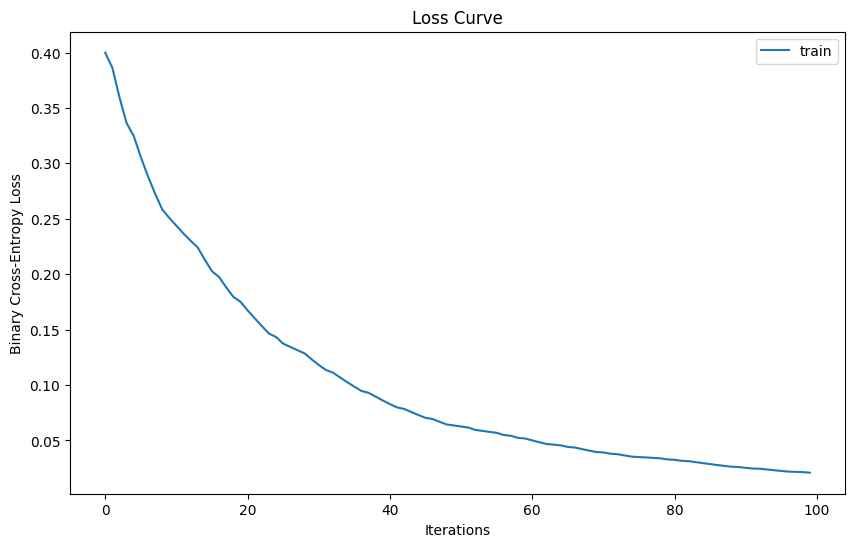

In [23]:
# draw the loss curve
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['logloss'], label='train')
# plt.plot(evals_result['eval']['logloss'], label='eval')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Binary Cross-Entropy Loss')
plt.show()

In [24]:
pred_y = bst.predict(xgb.DMatrix(validate_x))
pred_y_label = np.where(pred_y >= 0.5, 1, 0)

confusion_matrix(validate_y, pred_y_label)

array([[3924,    3],
       [  26,  591]], dtype=int64)

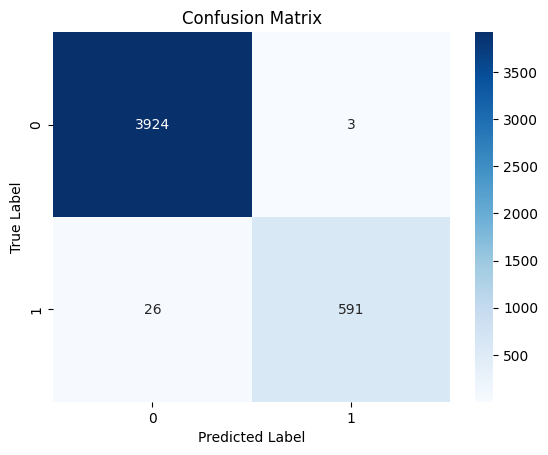

In [25]:
# draw the confusion matrix
cm = confusion_matrix(validate_y, pred_y_label, labels=
                      [0, 1])
cm = pd.DataFrame(cm)
sns.heatmap(cm, annot = True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [15]:
accuracy_score(validate_y, pred_y_label)

0.9951584507042254

Text(0.5, 0, 'Numbers of Times The Feature Is Used In a Model')

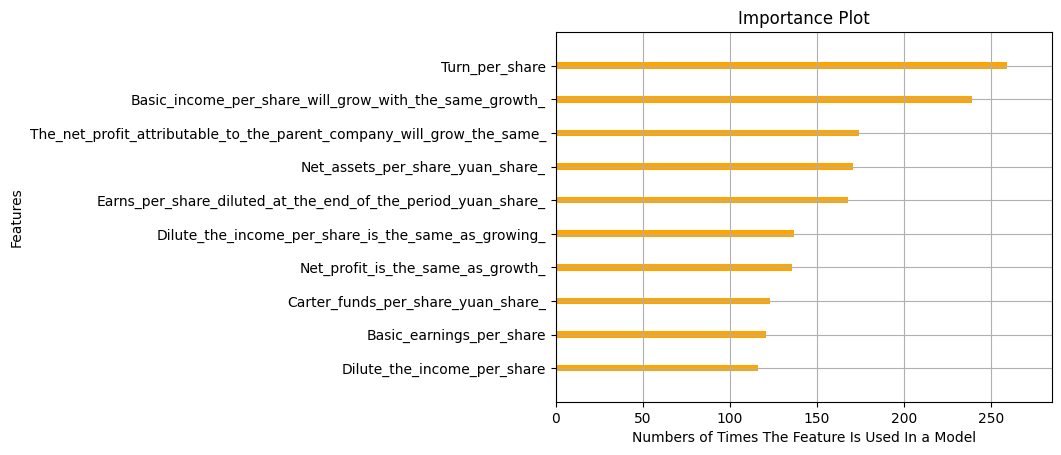

In [29]:
xgb.plot_importance(bst, importance_type='weight', max_num_features=10, show_values=False, title='Importance Plot', color = 'orange')
plt.xlabel('Numbers of Times The Feature Is Used In a Model')